# Автоэнкодер

## Подключение библиотек и загрузка датасета


In [ ]:
import numpy as np
import torch
import torchvision
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchshow as ts
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms, datasets
import torchshow as ts
import torchvision
import io
import requests
import PIL
from IPython.display import clear_output

In [ ]:
pip install torchshow

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
CIFAR10_train_val = datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transforms.ToTensor())
CIFAR10_train, CIFAR10_val = random_split(CIFAR10_train_val, [0.8, 0.2])

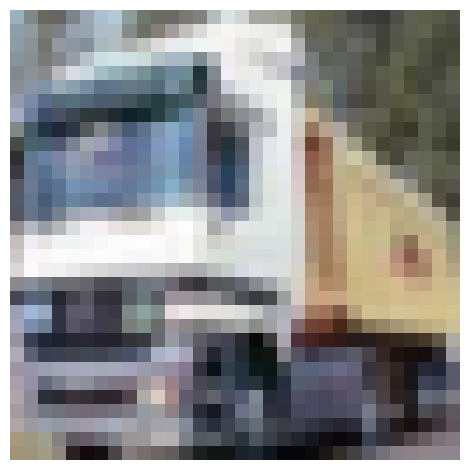

In [ ]:
img, cls = CIFAR10_train_val[1]
ts.show(img)


In [ ]:
img.shape

torch.Size([3, 32, 32])

## Необходимые функции

In [ ]:
def run_epoch(ae, opt, loss_func, dataloader, is_train=True):
    ae.train(is_train)
    total_loss = 0.0
    for batch in tqdm(dataloader):
        x = batch[0].to(device)
        x_hat, mu, logvar = ae(x)
        loss = loss_func(x, x_hat, mu, logvar)
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
def plot_loss(loss, title, num_epochs):
    plt.title(title)
    plt.plot(loss)
    plt.grid()
    plt.xticks(np.arange(num_epochs))
    step = max(1, num_epochs // 10)
    plt.xticks(np.arange(0, num_epochs, step))

def plot_losses(train, val, num_epochs):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plot_loss(train, f'Train Loss = {train[-1]}', num_epochs)
    plt.subplot(1, 2, 2)
    plot_loss(val, f'Val Loss = {val[-1]}', num_epochs)
    plt.show()

In [ ]:
def show_examples(ae, dataset, size):
    ae.eval()
    with torch.no_grad():
        idxs = np.random.randint(0, len(dataset), size)
        x = torch.stack([dataset[i][0] for i in idxs]).to(device)
        y,_,_  = ae.process(x)
        print("Original images")
        ts.show(x, nrows=1, figsize=(12, 2))
        print("Reconstructed")
        ts.show(y, nrows=1, figsize=(12, 2))

In [ ]:
def run_train_loop(ae, opt, loss, train_loader, val_loader, num_epochs, ex_size):
    train_hist = []
    val_hist = []
    for e in range(num_epochs):
        print("Trainin...")
        train_loss = run_epoch(ae, opt, loss, train_loader)
        train_hist.append(train_loss)
        print("Validating...")
        val_loss = run_epoch(ae, opt, loss, val_loader, is_train=False)
        val_hist.append(val_loss)
        clear_output()
        plot_losses(train_hist, val_hist, num_epochs)
        show_examples(ae, val_loader.dataset, ex_size)

In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    recon_loss = torch.sum((x - x_hat) ** 2)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = recon_loss + kl_divergence
    return loss

In [ ]:
def show_enc_dist(ae, xi, yi, dataset, size):
    idxs = np.random.randint(0, len(dataset), size)
    ae.eval()
    with torch.no_grad():
        z, m, s = ae.encode(torch.stack([dataset[i][0] for i in idxs]).to(device))
    x = z[:, xi].cpu().numpy()
    y = z[:, yi].cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c = [dataset[i][1] for i in idxs])
    plt.show()

## 1 эксперимент (Простая полносвязная сеть, 10 эпох, размерность латентного пространства равна 8)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=(3, 32, 32)):
        super().__init__()

        self.encoder_common = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(img_shape), 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU()
        )
        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_s = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Sigmoid(),
            nn.Unflatten(1, img_shape)
        )

    def encode(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x)).to(device)
        return m + s * self.N.sample(m.shape).to(device)

    def forward(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x))
        z = m + s * self.N.sample(m.shape).to(m.device)
        y = self.decoder(z)
        return y, m, s

    def process(self, x):
        return self(x)

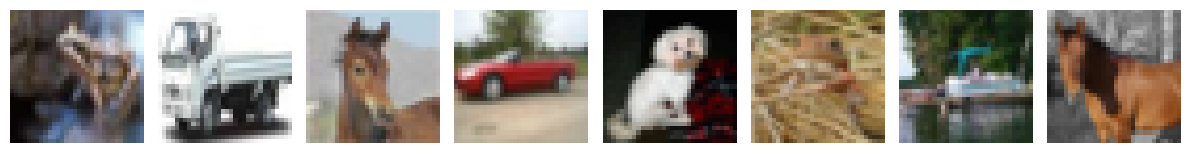

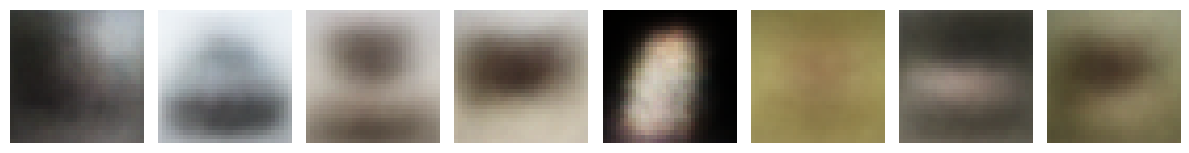

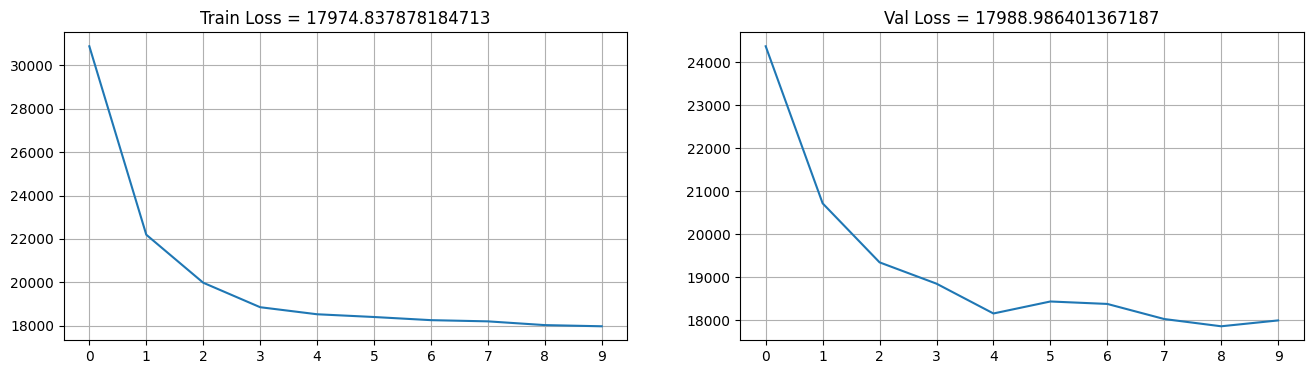

Original images
Reconstructed


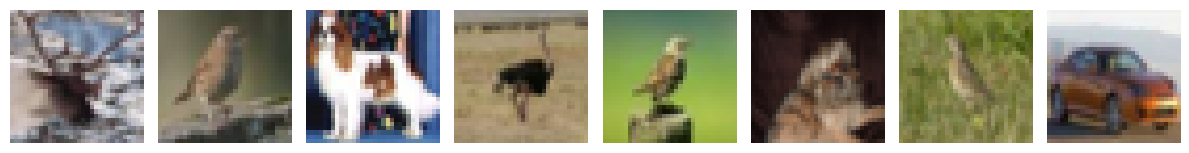

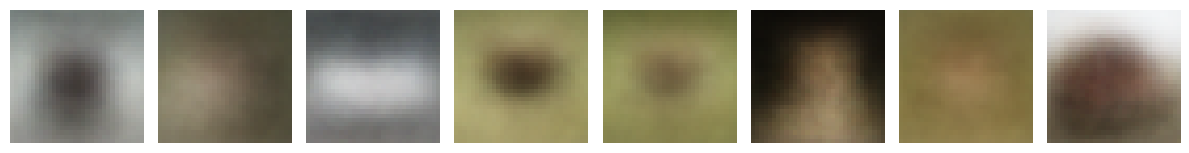

In [ ]:
batch_size = 256
num_epochs = 10
lat_dim = 8
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

In [ ]:
data, labels = next(iter(val_loader))

In [ ]:
img = data[0].to(device)
sae.encode(img)

tensor([[ 0.5350,  0.5384, -0.6062,  0.2467,  0.3936, -0.3963, -0.1113, -0.1820]],
       device='mps:0', grad_fn=<AddBackward0>)

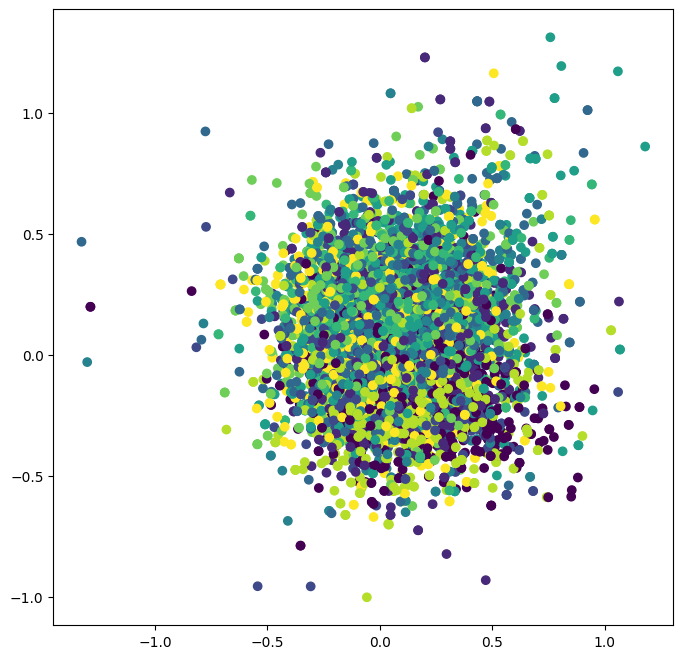

In [ ]:
show_enc_dist(sae, 0, 1, CIFAR10_val, 10000)

## Выводы
Модель получилось достаточно неточной, картинки не воспроизводятся с должным качеством. При этом уже после 5-6 эпох модель практически перестает обучаться, что говорит о невозможности продолжения обучения. Это может быть связано с достаточно неглубокой архитектурой сети, а также достаточно

## 2 эксперимент (Простая полносвязная сеть, 25 эпох, размерность латентного пространства равна 64)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=(3, 32, 32)):
        super().__init__()

        self.encoder_common = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(img_shape), 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU()
        )
        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_s = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Sigmoid(),
            nn.Unflatten(1, img_shape)
        )

    def encode(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x)).to(device)
        return m + s * self.N.sample(m.shape).to(device)

    def forward(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x))
        z = m + s * self.N.sample(m.shape).to(m.device)
        y = self.decoder(z)
        return y, m, s

    def process(self, x):
        return self(x)

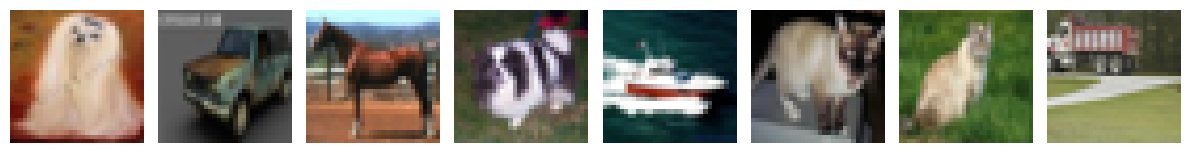

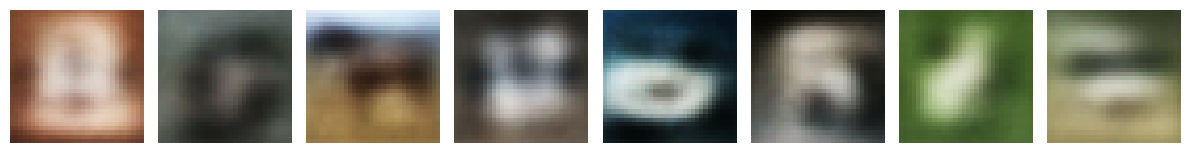

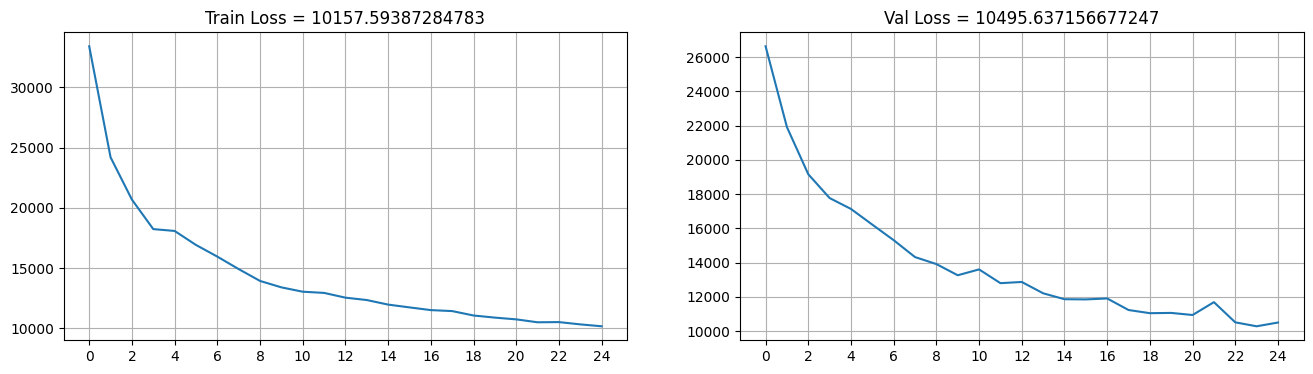

Original images
Reconstructed


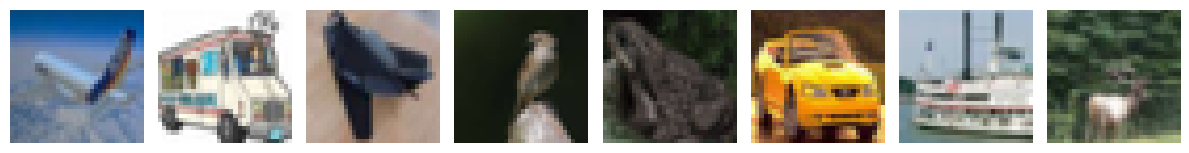

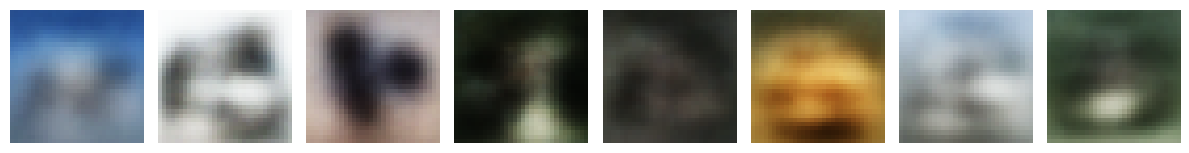

In [ ]:
batch_size = 256
num_epochs = 25
lat_dim = 64
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

In [ ]:
data, labels = next(iter(val_loader))

In [ ]:
img = data[0].to(device)
sae.encode(img)

tensor([[ 2.3316e-02, -8.7812e-02,  3.9431e-02, -9.4749e-02,  2.5440e-02,
         -2.4672e-01,  1.7930e-02, -1.4379e-01,  5.3708e-02, -2.3491e-02,
         -2.8311e-02,  3.4539e-02, -8.1540e-02,  2.2716e-02, -2.6755e-05,
          1.5939e-01, -2.4062e-03, -1.1761e-01,  2.8423e-03,  6.3457e-02,
         -1.0190e-01, -2.5829e-01, -2.2648e-01,  1.0173e-01,  1.4692e-01,
         -2.1394e-02, -1.0961e-02,  1.0109e-01, -1.2993e-01,  2.4425e-02,
          1.0641e-01, -1.4229e-02, -3.0756e-02, -9.3192e-03,  2.7916e-02,
         -1.7421e-01,  2.4477e-01,  2.2175e-02,  1.5356e-01, -1.4704e-01,
         -8.2547e-02, -1.6596e-01,  1.1263e-01,  1.0123e-01,  1.6246e-01,
         -3.3353e-02,  1.0106e-01, -1.7464e-01,  4.0584e-03, -9.5848e-02,
         -1.1014e-01,  8.2992e-02, -1.3961e-01, -1.1414e-01,  1.8822e-01,
         -1.2351e-01,  1.5113e-01,  2.0128e-01,  2.1962e-03, -1.5727e-02,
          3.6010e-02, -9.9156e-03, -4.0804e-02,  5.5062e-02]], device='mps:0',
       grad_fn=<AddBackward0>)

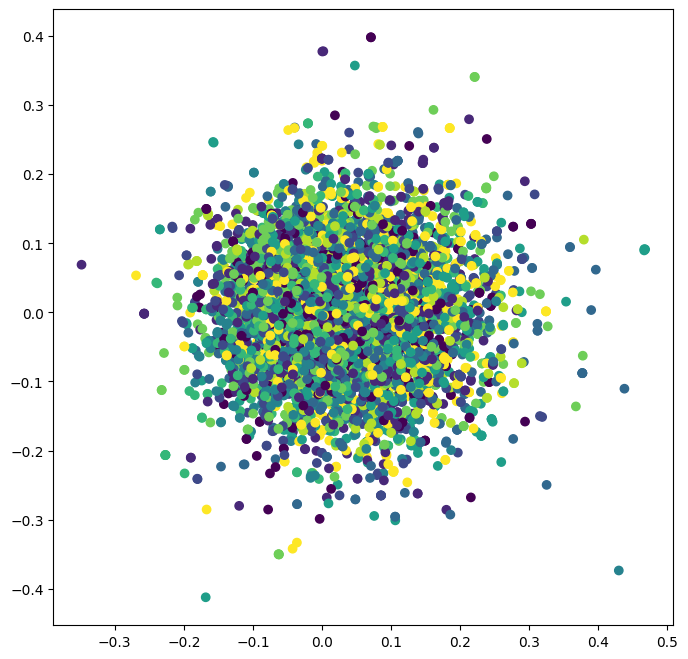

In [ ]:
show_enc_dist(sae, 0, 1, CIFAR10_val, 10000)

## Выводы
Модель показывет неплохое качество работы, полученные картики похожи на исходные. Также по графикам видно, что модель можно продолжать обучать, что позволит уменьшить loss.

## 3 эксперимент (Простая полносвязная сеть, dropout, 25 эпох, размерность латентного пространства равна 256)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=(3, 32, 32), dropout_rate=0.2):
        super().__init__()

        self.encoder_common = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(img_shape), 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )
        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_s = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, np.prod(img_shape)),
            nn.Sigmoid(),
            nn.Unflatten(1, img_shape)
        )

    def encode(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x)).to(device)
        return m + s * self.N.sample(m.shape).to(device)

    def forward(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x))
        z = m + s * self.N.sample(m.shape).to(m.device)
        y = self.decoder(z)
        return y, m, s

    def process(self, x):
        return self(x)

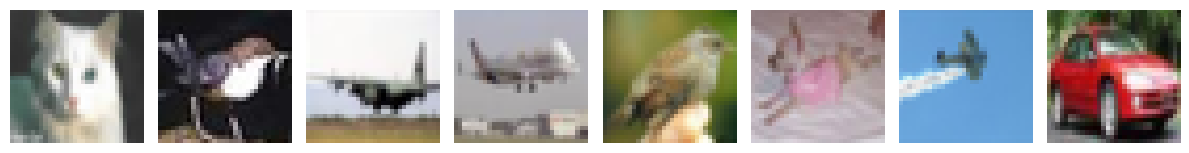

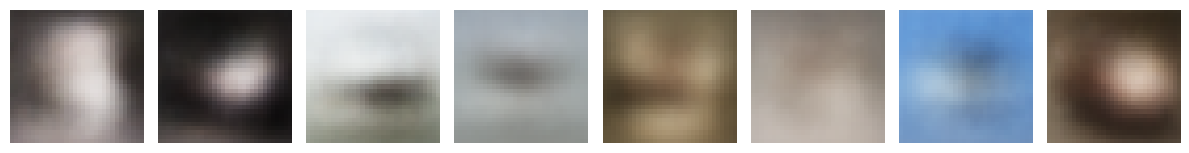

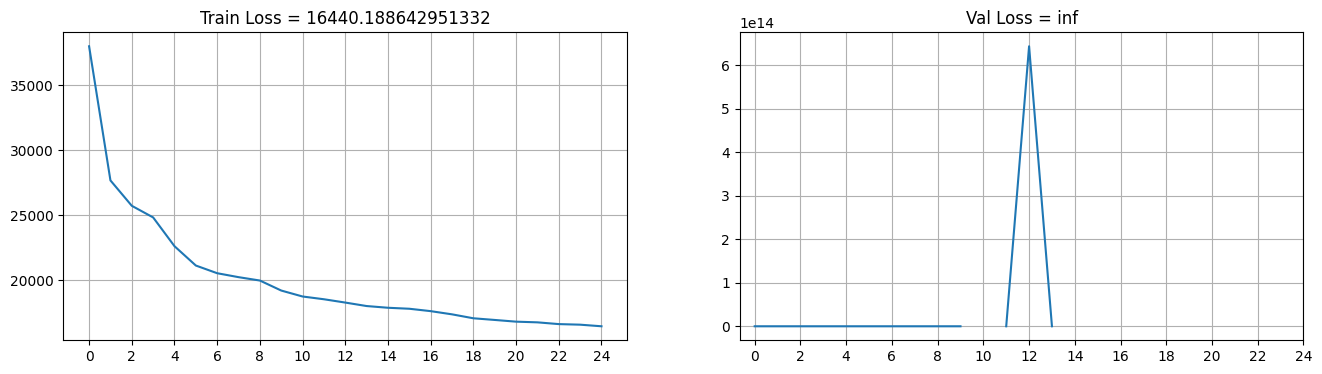

Original images
Reconstructed


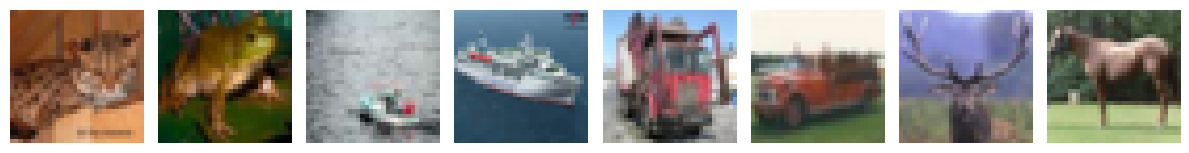

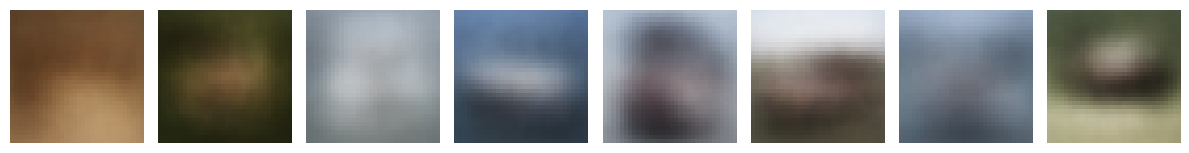

In [ ]:
batch_size = 256
num_epochs = 25
lat_dim = 256
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

In [ ]:
data, labels = next(iter(val_loader))

In [ ]:
img = data[0].to(device)
sae.encode(img)

tensor([[-0.0300,  0.0377,  0.0296,  0.0622, -0.0063,  0.0136,  0.0044,  0.1187,
         -0.0383, -0.0458,  0.0150,  0.0249,  0.0319, -0.0015,  0.0301, -0.0101,
         -0.0189, -0.0139, -0.0185,  0.0876, -0.0245, -0.0286, -0.0401,  0.0799,
          0.0044, -0.0161,  0.0315,  0.0870,  0.0127,  0.1755, -0.0529,  0.0853,
          0.0082,  0.0240,  0.0402,  0.0057, -0.0350,  0.0239, -0.0152, -0.0175,
          0.0339, -0.0005,  0.0088, -0.0003,  0.0277,  0.0229,  0.0221, -0.1049,
          0.0284,  0.0135,  0.0064, -0.0098, -0.0297,  0.0292,  0.0265, -0.0080,
          0.0317, -0.0397, -0.0512,  0.0194, -0.0260,  0.0182,  0.0202, -0.0252,
         -0.0305,  0.0068, -0.0287,  0.0379,  0.1169,  0.0152,  0.0727,  0.0632,
         -0.0447,  0.0147,  0.0779, -0.0425, -0.0140,  0.0119,  0.0115,  0.0040,
         -0.0292, -0.1002,  0.0694,  0.0277,  0.0373,  0.0129, -0.0694,  0.0165,
         -0.0330,  0.0368,  0.0841, -0.0053,  0.0542, -0.0745,  0.0604,  0.0013,
         -0.0105,  0.0529, -

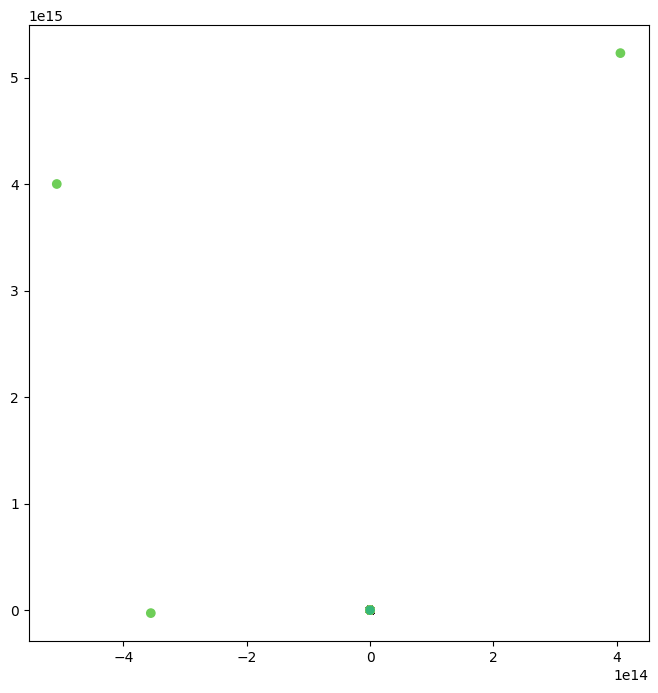

In [ ]:
show_enc_dist(sae, 0, 1, CIFAR10_val, 10000)

## Выводы
При обучении данной модели скорее всего произошло взрывное увеличение loss, в результате чего модель не смогла обучиться. Для предотвращения подобных ситуаций в следующих моделях будем использовать torch.clamp(..., -10, 10).

## 4 эксперимент (Сверточная сеть, dropout, 25 эпох, размерность латентного пространства равна 64)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=(3, 32, 32), dropout_rate=0.2):
        super().__init__()
        self.img_shape = img_shape

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(img_shape[0], 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate)
        )
        self.flatten_dim = 128 * (img_shape[1] // 8) * (img_shape[2] // 8)

        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_s = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.flatten_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

        self.decoder_deconv = nn.Sequential(
            nn.Unflatten(1, (128, img_shape[1] // 8, img_shape[2] // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.ConvTranspose2d(32, img_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        elif x.dim() == 2:
            x = x.view(-1, *self.img_shape)

        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        m = self.encoder_m(x)
        logvar = self.encoder_s(x)
        logvar = torch.clamp(logvar, -10, 10)
        s = torch.exp(logvar)
        eps = self.N.sample(m.shape).to(m.device)
        return m + s * eps, m, s

    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.decoder_deconv(x)
        return x

    def forward(self, x):
        z, m, s = self.encode(x)
        y = self.decode(z)
        return y, m, s

    def process(self, x):
        return self.forward(x)


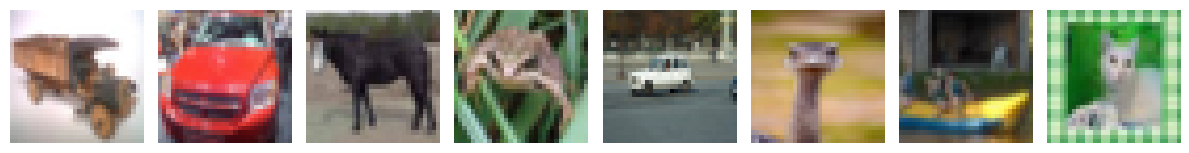

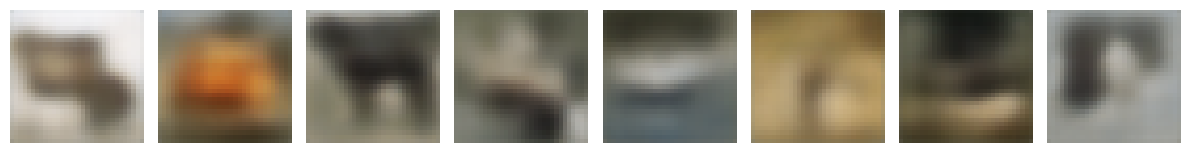

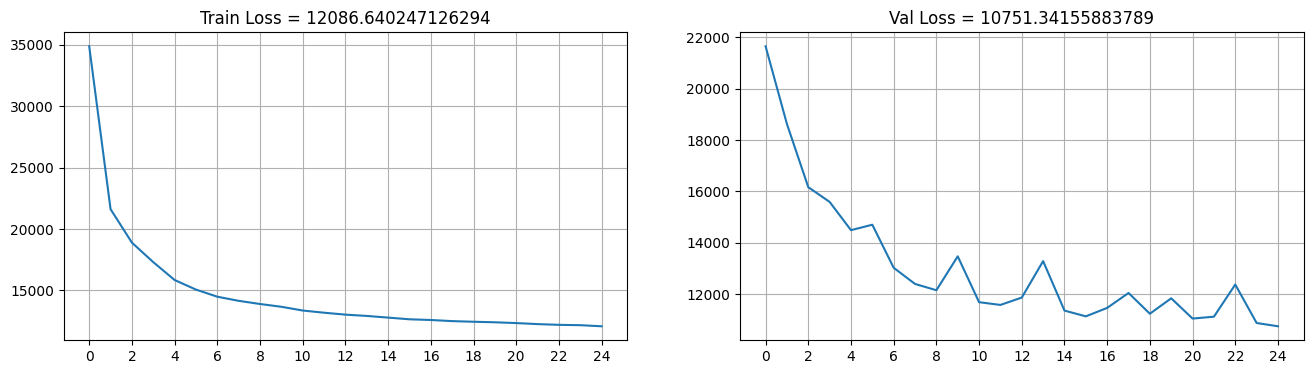

Original images
Reconstructed


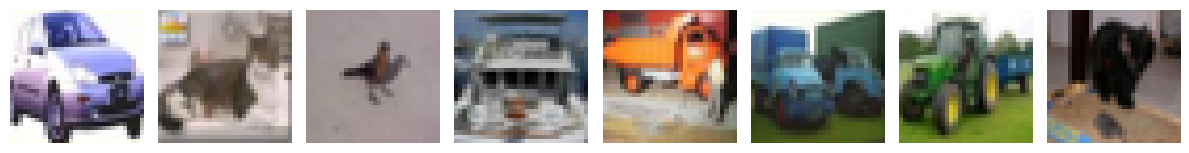

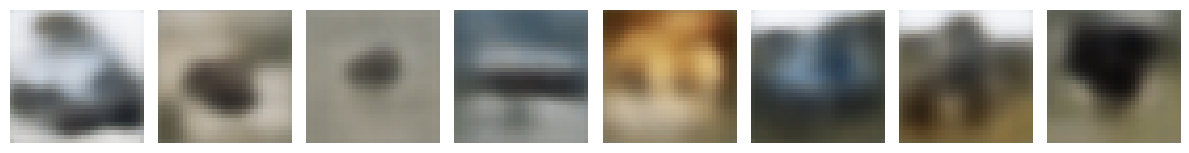

In [ ]:
batch_size = 256
num_epochs = 25
lat_dim = 64
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

In [ ]:
data, labels = next(iter(val_loader))

In [ ]:
img = data[0].to(device)
sae.encode(img)

(tensor([[ 0.1118,  0.0617, -0.1755, -0.1259, -0.0613,  0.0567, -0.0461,  0.0084,
          -0.0317,  0.0228,  0.1139, -0.2014,  0.1334, -0.0439, -0.0102, -0.0098,
          -0.0794,  0.0353,  0.1879, -0.0997, -0.0842, -0.0207,  0.0641,  0.0058,
          -0.1959,  0.0155,  0.0121, -0.0295,  0.0677, -0.2357, -0.1523,  0.1289,
          -0.1552,  0.1203,  0.0882,  0.0299, -0.0097, -0.0476,  0.0882,  0.0503,
          -0.2052,  0.1101,  0.0620,  0.0056, -0.1754, -0.0933,  0.0149, -0.0276,
          -0.1023, -0.1337,  0.1585,  0.0135,  0.1575, -0.0292,  0.2015,  0.0354,
          -0.1410, -0.1363, -0.0092,  0.0823,  0.0267,  0.0763, -0.0785, -0.1429]],
        device='mps:0', grad_fn=<AddBackward0>),
 tensor([[ 0.1124,  0.0619, -0.1763, -0.1259, -0.0620,  0.0579, -0.0440,  0.0096,
          -0.0327,  0.0230,  0.1129, -0.2030,  0.1327, -0.0425, -0.0091, -0.0099,
          -0.0793,  0.0345,  0.1870, -0.1000, -0.0854, -0.0218,  0.0623,  0.0026,
          -0.1956,  0.0158,  0.0126, -0.0303,  

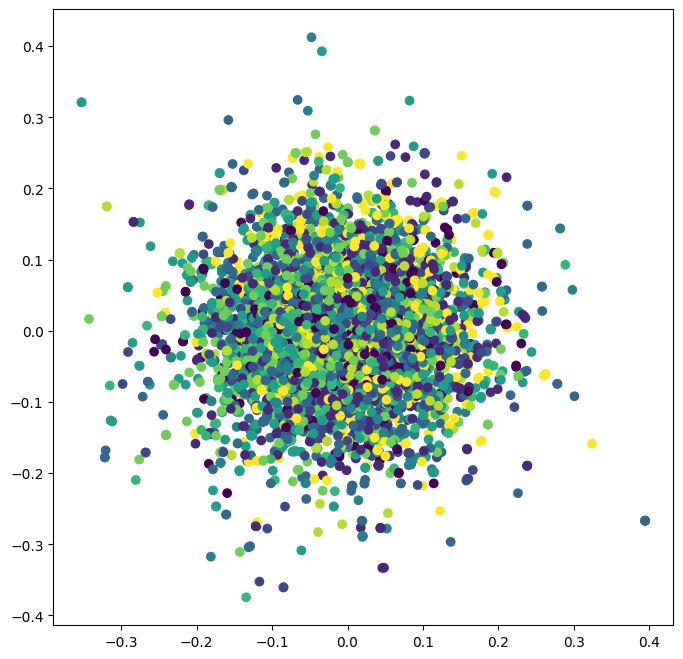

In [ ]:
show_enc_dist(sae, 0, 1, CIFAR10_val, 10000)

## Выводы
Модель показывет неплохое качество работы, но полученным изображениям не хватает деталей. Заметного улучшения по сравнения с простой полносвязной сетью нет.
Это может возникать из-за ограниченного размера латентного пространства, а также достаточно низкого качества исходных изображений.

## 5 эксперимент (Глубокая сверточная сеть, dropout, BatchNorm, 50 эпох, размерность латентного пространства равна 128)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=(3, 32, 32), dropout_rate=0.2):
        super().__init__()
        self.img_shape = img_shape

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(img_shape[0], 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate)
        )

        self.flatten_dim = 128 * 4 * 4

        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_logvar = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)


        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.flatten_dim),
            nn.BatchNorm1d(self.flatten_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.decoder_deconv = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),

            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(32, img_shape[0], kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):

        if x.dim() == 3:
            x = x.unsqueeze(0)
        elif x.dim() == 2:
            x = x.view(-1, *self.img_shape)
        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        m = self.encoder_m(x)
        logvar = self.encoder_logvar(x)
        logvar = torch.clamp(logvar, -10, 10)
        s = torch.exp(0.5 * logvar)
        eps = self.N.sample(m.shape).to(m.device)
        return m + s * eps, m, s

    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.decoder_deconv(x)
        return x

    def forward(self, x):
        z, m, s = self.encode(x)
        y = self.decode(z)
        return y, m, s

    def process(self, x):
        return self.forward(x)


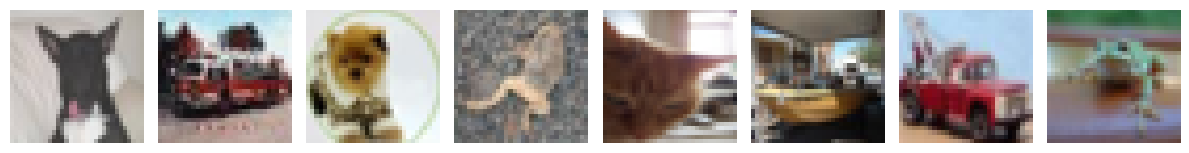

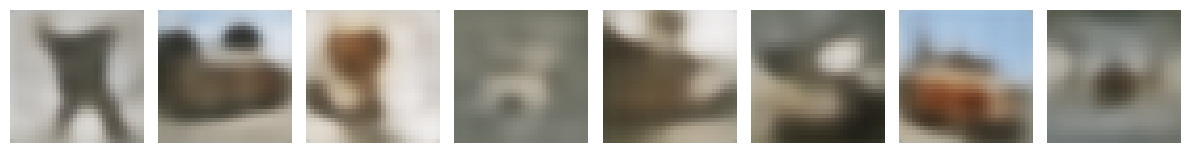

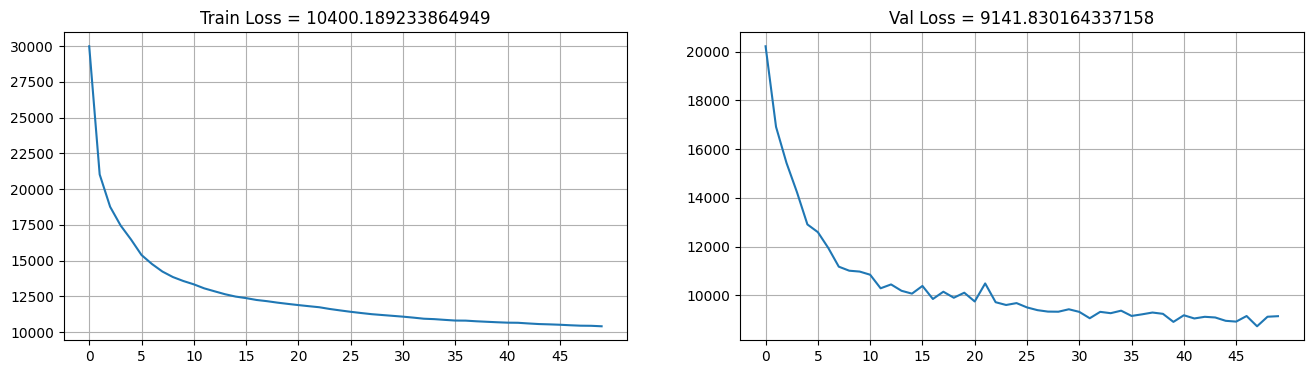

Original images
Reconstructed


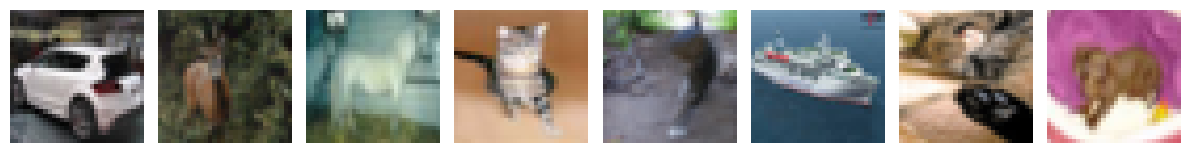

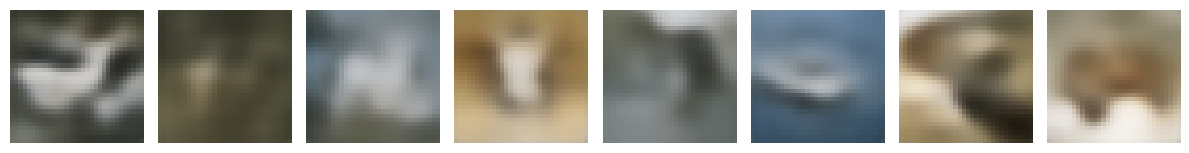

In [ ]:
batch_size = 256
num_epochs = 50
lat_dim = 128
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

In [ ]:
data, labels = next(iter(val_loader))

In [ ]:
img = data[0].to(device)
sae.encode(img)

(tensor([[ 5.7861e-02, -7.3551e-02,  7.5945e-02,  1.5617e-02, -8.6887e-02,
           2.2058e-01,  1.8387e-01, -5.6088e-02, -9.1071e-02,  5.5705e-02,
          -7.0683e-02,  6.3089e-02,  5.7083e-02,  1.8386e-01,  1.2383e-02,
          -1.8619e-02,  3.0129e-02, -7.5005e-02, -1.3034e-01, -1.7415e-01,
          -2.0843e-01,  1.9214e-03, -4.8860e-02,  4.9647e-02, -5.6631e-02,
           2.2315e-01, -5.7316e-02, -2.3308e-02, -3.6855e-02, -3.7200e-02,
           4.0452e-02, -1.5835e-02, -3.2690e-02,  4.6303e-02, -2.9648e-02,
          -1.6107e-02,  6.2949e-02, -1.6852e-02, -1.6114e-02,  6.6659e-02,
           3.1265e-02, -1.2672e-02, -1.1534e-01,  4.3815e-02, -1.8714e-01,
          -1.2865e-01,  2.3816e-02,  5.7136e-02,  1.1059e-01, -1.6968e-02,
          -3.8886e-02,  1.4222e-02, -7.9920e-03, -9.4417e-02,  7.3505e-02,
          -7.1239e-02, -3.0050e-02, -1.5169e-02,  9.2036e-03, -3.8078e-02,
           1.8104e-01,  3.2235e-02, -2.5201e-02,  7.4287e-02,  4.1723e-02,
           1.3774e-01,  2

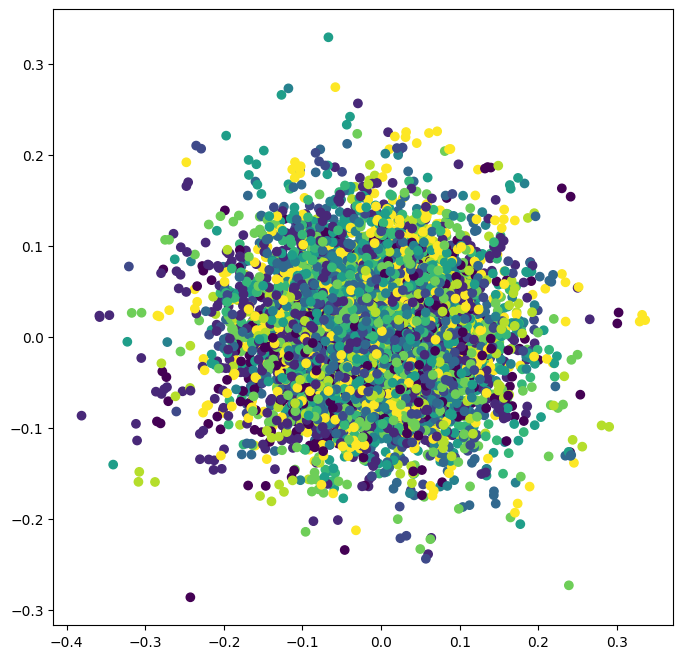

In [ ]:
show_enc_dist(sae, 0, 1, CIFAR10_val, 10000)

## Выводы
Модель показывет хорошее качество работы, некоторые изображения достаточно сильно похожи на исходные. По сравнению с предыдущей нейросетью увеличено латентное пространство, количество эпох, а также добавлен batchnorm. Но досточно маленькое разрешение исходных картинок не позволяет модели находить более сложные зависимости.


In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=(3, 32, 32), dropout_rate=0.2):
        super().__init__()
        self.img_shape = img_shape

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(img_shape[0], 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        self.flatten_dim = 128 * (img_shape[1] // 8) * (img_shape[2] // 8)

        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_s = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.flatten_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

        self.decoder_deconv = nn.Sequential(
            nn.Unflatten(1, (128, img_shape[1] // 8, img_shape[2] // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.ConvTranspose2d(32, img_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        elif x.dim() == 2:
            x = x.view(-1, *self.img_shape)

        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        m = self.encoder_m(x)
        logvar = self.encoder_s(x)
        logvar = torch.clamp(logvar, -10, 10)
        s = torch.exp(logvar)
        eps = self.N.sample(m.shape).to(m.device)
        return m + s * eps, m, s

    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.decoder_deconv(x)
        return x

    def forward(self, x):
        z, m, s = self.encode(x)
        y = self.decode(z)
        return y, m, s

    def process(self, x):
        return self.forward(x)


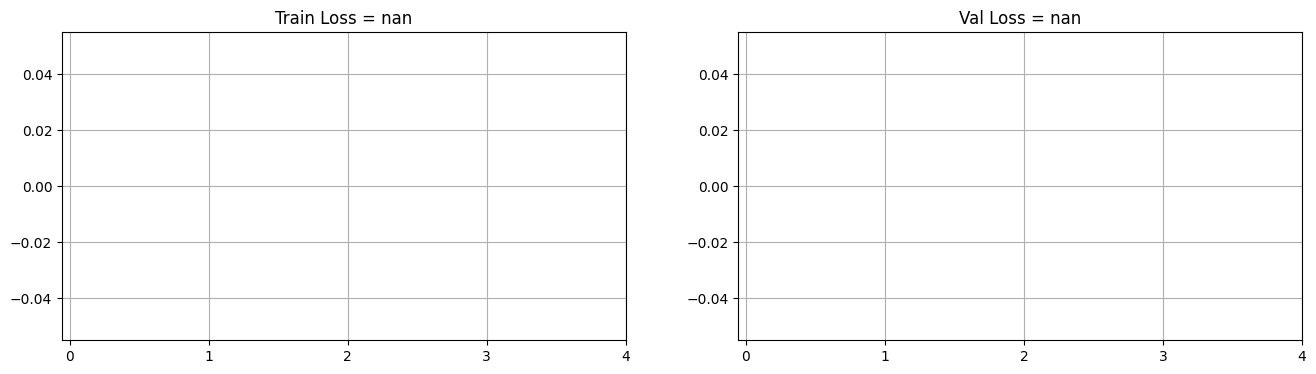

Original images


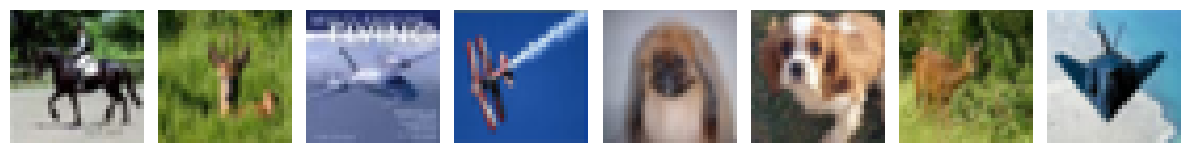

Reconstructed


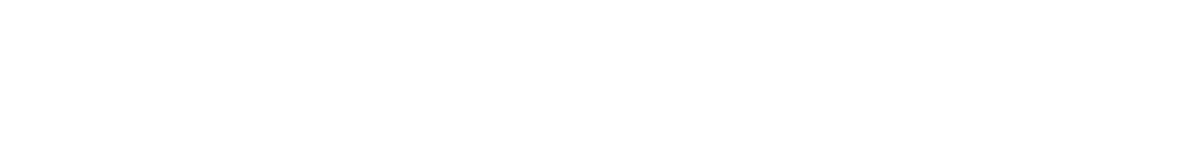

Trainin...


 16%|█▌        | 3234/20000 [00:18<01:36, 173.88it/s]


KeyboardInterrupt: 

In [ ]:
batch_size = 2
num_epochs = 5
lat_dim = 32
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

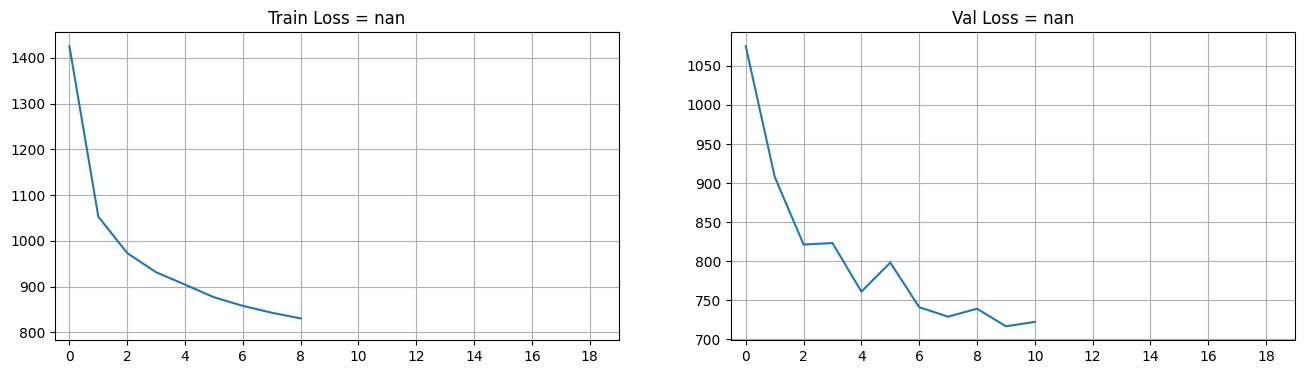

Original images


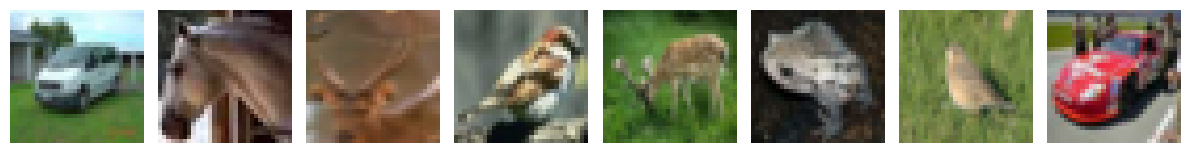

Reconstructed


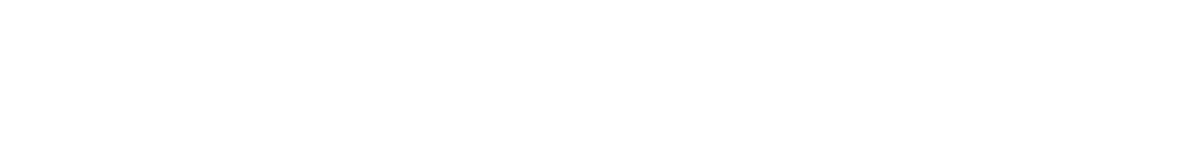

Trainin...


100%|██████████| 2500/2500 [00:21<00:00, 116.46it/s]


Validating...


 23%|██▎       | 145/625 [00:00<00:01, 259.86it/s]


KeyboardInterrupt: 

In [ ]:
batch_size = 16
num_epochs = 20
lat_dim = 128
ex_size = 8

train_loader = DataLoader(CIFAR10_train, batch_size)
val_loader = DataLoader(CIFAR10_val, batch_size)

sae = VariationalAutoEncoder(lat_dim).to(device)
sae_opt = optim.Adam(sae.parameters())
run_train_loop(sae, sae_opt, vae_loss, train_loader, val_loader, num_epochs, ex_size)

## Результаты
На данном датасете сложная сверточная нейросеть показала лучший результат, но различия с простой полносвязной сетью достаточно незначительны, при этом обучение простой сети занимает существенно меньше времени.
Также стоит отметить, что распределение точек латентного пространства на графиках соответсвуют задачам вариационного автоэнкодера, а полученная область точек говорит об успешном применении KL-дивергенции.